# Time Series Analysis with Non-Linear Models for Energy Consumption Prediction

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# --- Imports & Settings ---
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Libraries imported.')


Libraries imported.


In [ ]:
# Configure GPU memory growth
try:
    # Preventing TensorFlow from taking all GPU memory
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    print("GPU Available:", gpus)
    print("Tensorflow version:", tf.__version__)
except RuntimeError as e:
    print("GPU configuration error:", e)

# Enabling mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy set to mixed_float16")

GPU memory growth enabled
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.19.0
Mixed precision policy set to mixed_float16


In [ ]:
FILENAME = 'hourlyLoadDataIndia.xlsx'
if not os.path.exists(FILENAME):
    raise FileNotFoundError(f"File not found: {FILENAME}. Place it in the working directory or update FILENAME.")

if FILENAME.lower().endswith(('.xlsx', '.xls')):
    df = pd.read_excel(FILENAME)
else:
    df = pd.read_csv(FILENAME)

print('Loaded:', FILENAME)
print(df.shape)
display(df.head())


Loaded: hourlyLoadDataIndia.xlsx
(46728, 7)


,datetime,National Hourly Demand,Northen Region Hourly Demand,Western Region Hourly Demand,Eastern Region Hourly Demand,Southern Region Hourly Demand,North-Eastern Region Hourly Demand
0,2019-01-01 00:00:00,118690.67,33692.02,38522.22,13128.89,31681.83,1665.72
1,2019-01-01 01:00:00,116029.23,32534.39,38071.09,12737.53,31129.97,1556.24
2,2019-01-01 02:00:00,114044.14,31730.37,37680.10,12387.36,30760.87,1485.44
3,2019-01-01 03:00:00,113648.97,31529.25,37747.37,12301.12,30616.27,1454.96
4,2019-01-01 04:00:00,116290.05,32406.61,38101.80,12479.13,31839.38,1463.14


In [ ]:
print('Starting preprocessing...')

if 'datetime' not in df.columns:

    possible = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
    if possible:
        datetime_col = possible[0]
        df = df.rename(columns={datetime_col: 'datetime'})
    else:
        raise KeyError('No datetime column found')

TARGET_COL = 'National Hourly Demand'
if TARGET_COL not in df.columns:
    possible = [c for c in df.columns if 'national' in c.lower() or 'demand' in c.lower()]
    if possible:
        TARGET_COL = possible[0]
    else:
        raise KeyError('Target column not found')

df_processed = df[['datetime', TARGET_COL]].copy()
df_processed['datetime'] = pd.to_datetime(df_processed['datetime'])
df_processed.set_index('datetime', inplace=True)

# Time-based features
df_processed['hour'] = df_processed.index.hour
df_processed['dayofweek'] = df_processed.index.dayofweek
df_processed['month'] = df_processed.index.month
df_processed['year'] = df_processed.index.year
df_processed['quarter'] = df_processed.index.quarter
df_processed['dayofyear'] = df_processed.index.dayofyear

# Cyclical encodings
df_processed['hour_s'] = np.sin(2 * np.pi * df_processed.index.hour / 24)
df_processed['hour_c'] = np.cos(2 * np.pi * df_processed.index.hour / 24)
df_processed['month_s'] = np.sin(2 * np.pi * (df_processed.index.month - 1) / 12)
df_processed['month_c'] = np.cos(2 * np.pi * (df_processed.index.month - 1) / 12)
df_processed['doy_s'] = np.sin(2 * np.pi * df_processed.index.dayofyear / 365.25)
df_processed['doy_c'] = np.cos(2 * np.pi * df_processed.index.dayofyear / 365.25)

# Lag features
for i in range(1, 8):
    df_processed[f'lag_{i*24}h'] = df_processed[TARGET_COL].shift(i*24)
df_processed['lag_1h'] = df_processed[TARGET_COL].shift(1)
df_processed['lag_2h'] = df_processed[TARGET_COL].shift(2)

df_processed['rolling_mean_6h'] = df_processed[TARGET_COL].shift(1).rolling(window=6).mean()

# Dropping NaNs from shift/rolling
before = len(df_processed)
df_processed = df_processed.dropna()
after = len(df_processed)
print(f'Dropped {before - after} rows due to lag/rolling feature creation. Remaining rows: {after}')
display(df_processed.head())


Starting preprocessing...
Dropped 168 rows due to lag/rolling feature creation. Remaining rows: 46560


,National Hourly Demand,hour,dayofweek,month,year,quarter,dayofyear,hour_s,hour_c,month_s,...,lag_24h,lag_48h,lag_72h,lag_96h,lag_120h,lag_144h,lag_168h,lag_1h,lag_2h,rolling_mean_6h
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,120469.17,0,1,1,2019,1,8,0.000000,1.000000,0.0,...,114521.82,119765.83,121100.82,120713.06,119599.66,116461.83,118690.67,124606.56,130686.94,140240.218333
2019-01-08 01:00:00,117785.18,1,1,1,2019,1,8,0.258819,0.965926,0.0,...,111937.14,117061.73,118374.88,118268.12,116753.00,113978.80,116029.23,120469.17,124606.56,134581.190000
2019-01-08 02:00:00,116494.43,2,1,1,2019,1,8,0.500000,0.866025,0.0,...,109973.95,115051.17,116897.56,116660.42,115518.20,112632.51,114044.14,117785.18,120469.17,128937.310000
2019-01-08 03:00:00,116245.91,3,1,1,2019,1,8,0.707107,0.707107,0.0,...,109298.02,114425.56,116264.60,116049.37,115710.99,112561.19,113648.97,116494.43,117785.18,124498.858333
2019-01-08 04:00:00,118715.49,4,1,1,2019,1,8,0.866025,0.500000,0.0,...,111738.05,116743.71,118623.79,118441.36,118123.91,115098.64,116290.05,116245.91,116494.43,121048.031667


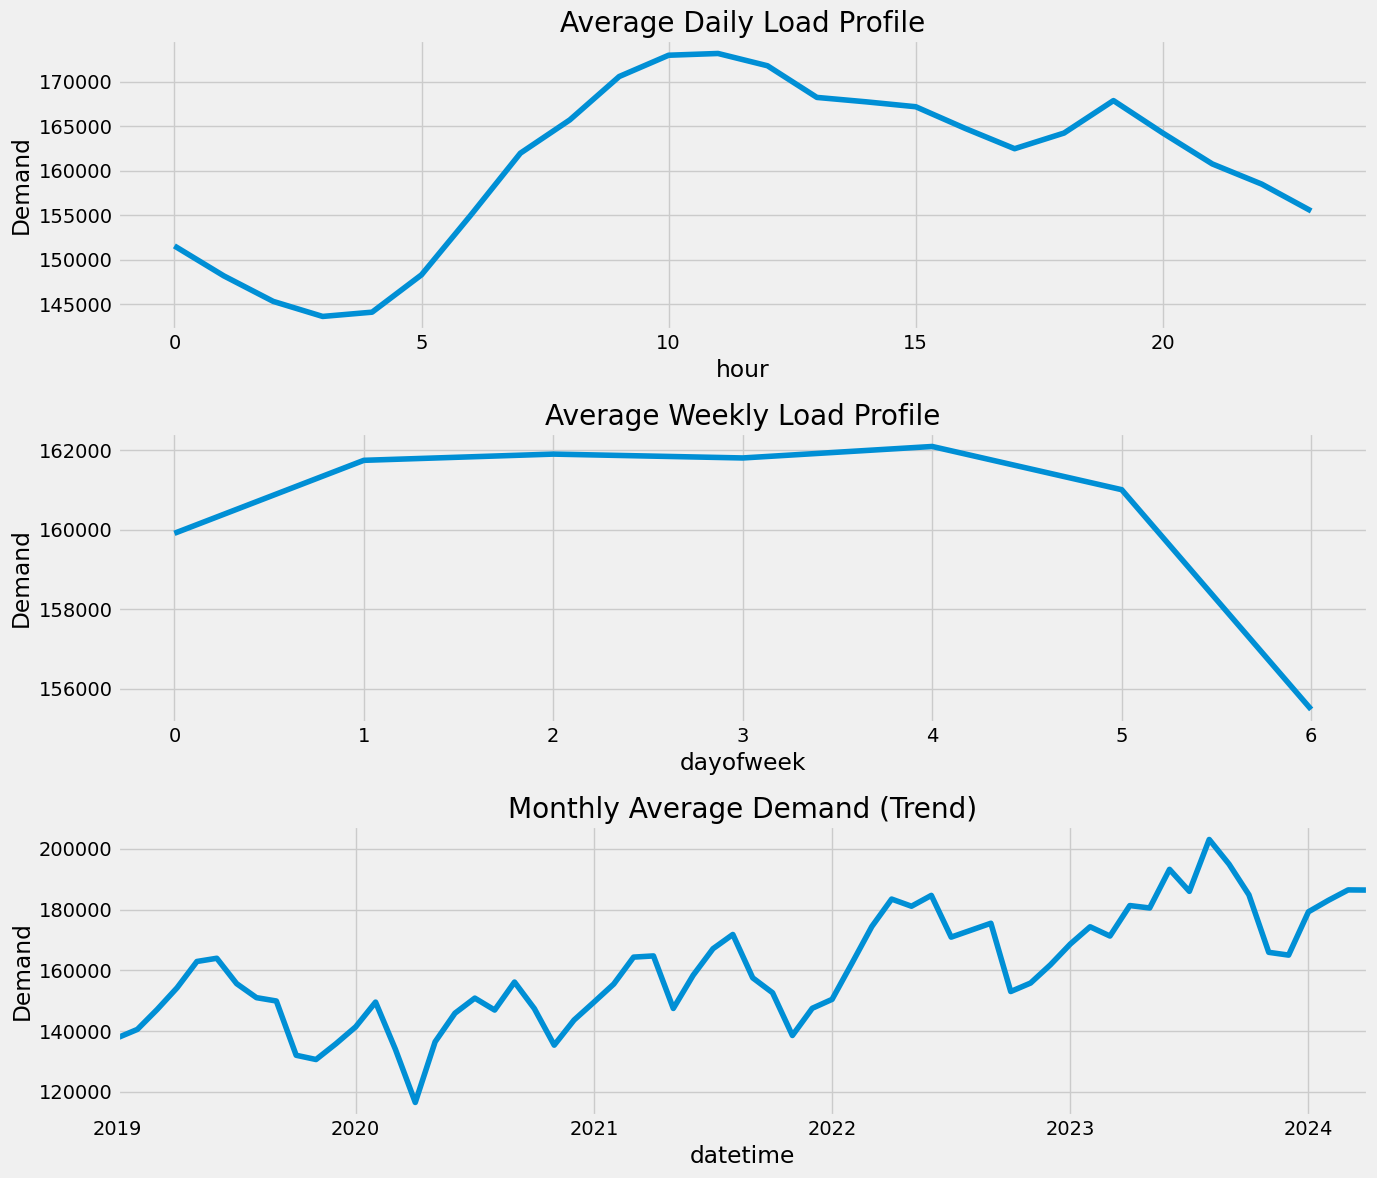

In [ ]:
# Seasonal patterns & trend
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
df_processed.groupby('hour')[TARGET_COL].mean().plot(ax=axes[0], title='Average Daily Load Profile')
axes[0].set_ylabel('Demand')
df_processed.groupby('dayofweek')[TARGET_COL].mean().plot(ax=axes[1], title='Average Weekly Load Profile')
axes[1].set_ylabel('Demand')
df_processed[TARGET_COL].resample('M').mean().plot(ax=axes[2], title='Monthly Average Demand (Trend)')
axes[2].set_ylabel('Demand')
plt.tight_layout()
plt.show()


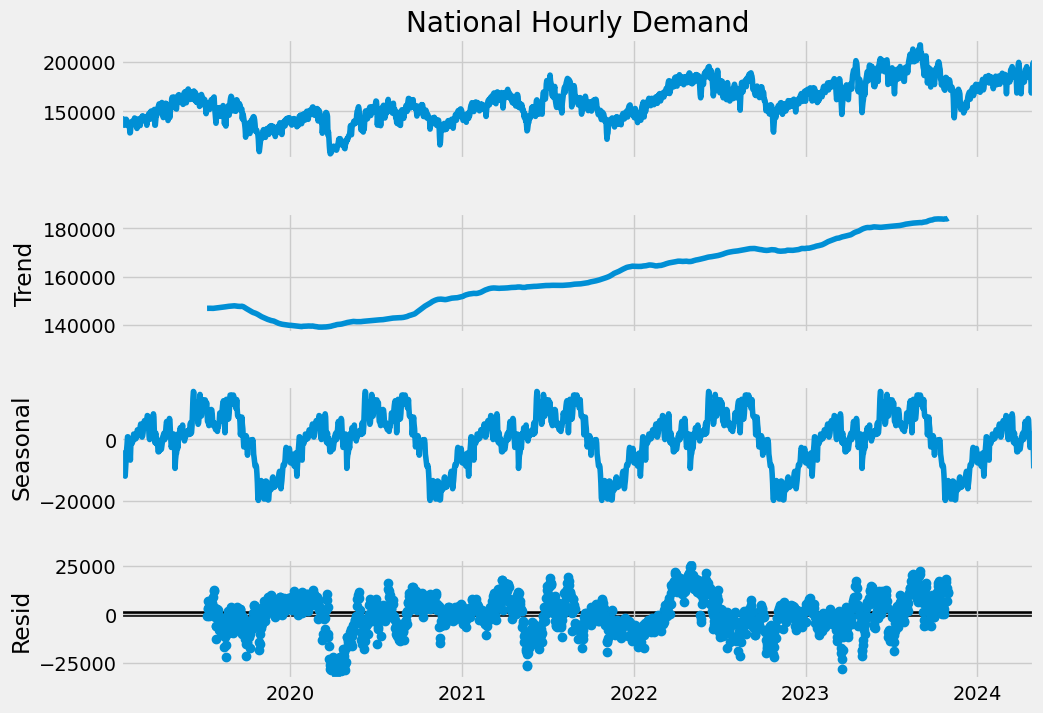

In [ ]:
# Decomposition (daily aggregated)
from statsmodels.tsa.seasonal import seasonal_decompose
daily = df_processed[TARGET_COL].resample('D').mean().dropna()
if len(daily) > 365 * 2:
    decomp = seasonal_decompose(daily, model='additive', period=365)
    fig = decomp.plot()
    fig.set_size_inches(12, 8)
    plt.show()
else:
    print('Not enough daily data for yearly decomposition (need >= 2 years).')


In [ ]:
# features, split
FEATURES = [
    'hour_s','hour_c','dayofweek','month_s','month_c','year','quarter','doy_s','doy_c',
    'lag_24h','lag_48h','lag_72h','lag_96h','lag_120h','lag_144h','lag_168h',
    'lag_1h','lag_2h','rolling_mean_6h'
]
X = df_processed[FEATURES]
y = df_processed[TARGET_COL]

split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print('Shapes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Training data from', X_train.index.min(), 'to', X_train.index.max())
print('Testing data from', X_test.index.min(), 'to', X_test.index.max())


Shapes:
(37248, 19) (9312, 19) (37248,) (9312,)
Training data from 2019-01-08 00:00:00 to 2023-04-08 23:00:00
Testing data from 2023-04-09 00:00:00 to 2024-04-30 23:00:00


In [ ]:
#Scaling features for linear models
scaler_lr = StandardScaler()
X_train_lr = pd.DataFrame(scaler_lr.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_lr = pd.DataFrame(scaler_lr.transform(X_test), index=X_test.index, columns=X_test.columns)

# MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100

print('Scaled features prepared for linear models.')


Scaled features prepared for linear models.


In [ ]:
#ML Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1, max_depth=10),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, n_jobs=-1, random_state=SEED)
}

performance_metrics = {}

print('Running TimeSeriesSplit CV (3 folds) for ML models...')
tscv = TimeSeriesSplit(n_splits=3)
for name, model in models.items():
    # For Linear Regression using scaled features
    if name == 'Linear Regression':
        X_for_cv = pd.concat([X_train_lr, X_test_lr])
        y_for_cv = pd.concat([y_train, y_test])
    else:
        X_for_cv = pd.concat([X_train, X_test])
        y_for_cv = pd.concat([y_train, y_test])

    scores = cross_val_score(model, X_for_cv, y_for_cv, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_cv = -scores
    print(f"{name} CV RMSE mean={rmse_cv.mean():.2f}, std={rmse_cv.std():.2f}")

    # Model Fit
    if name == 'Linear Regression':
        model.fit(X_train_lr, y_train)
        y_pred = model.predict(X_test_lr)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mpe = mape(y_test, y_pred)

    performance_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2, 'MAPE%': mpe}
    print(f"{name} test RMSE={rmse:.2f}, R2={r2:.4f}, MAPE={mpe:.2f}%")

print('\nML model evaluation complete.')


Running TimeSeriesSplit CV (3 folds) for ML models...
Linear Regression CV RMSE mean=2726.07, std=180.45
Linear Regression test RMSE=2988.11, R2=0.9766, MAPE=1.24%
Decision Tree CV RMSE mean=3784.95, std=591.16
Decision Tree test RMSE=4749.01, R2=0.9410, MAPE=1.80%
Random Forest CV RMSE mean=3158.64, std=592.41
Random Forest test RMSE=4072.99, R2=0.9566, MAPE=1.46%
XGBoost CV RMSE mean=3168.17, std=855.66
XGBoost test RMSE=4052.56, R2=0.9570, MAPE=1.27%

ML model evaluation complete.


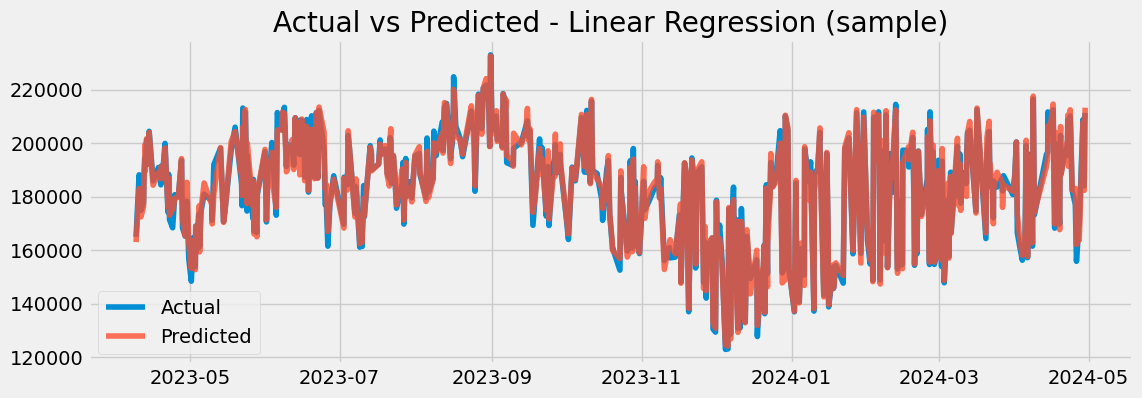

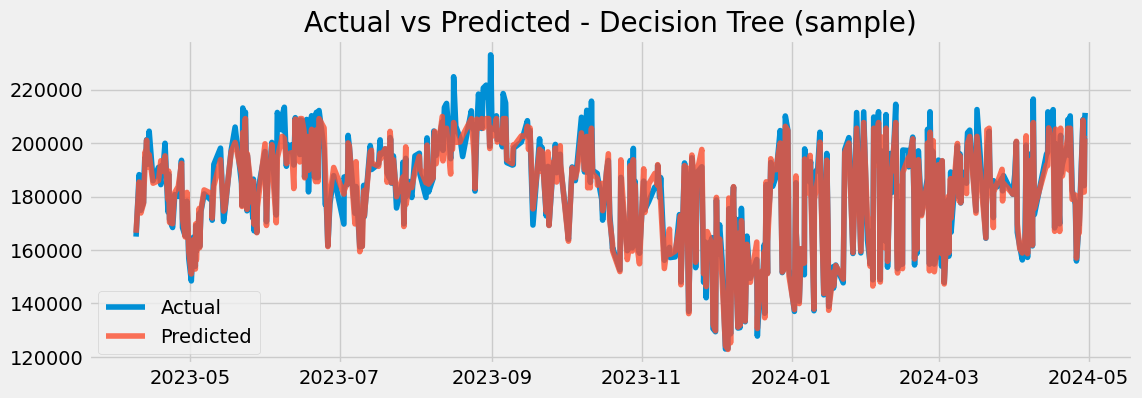

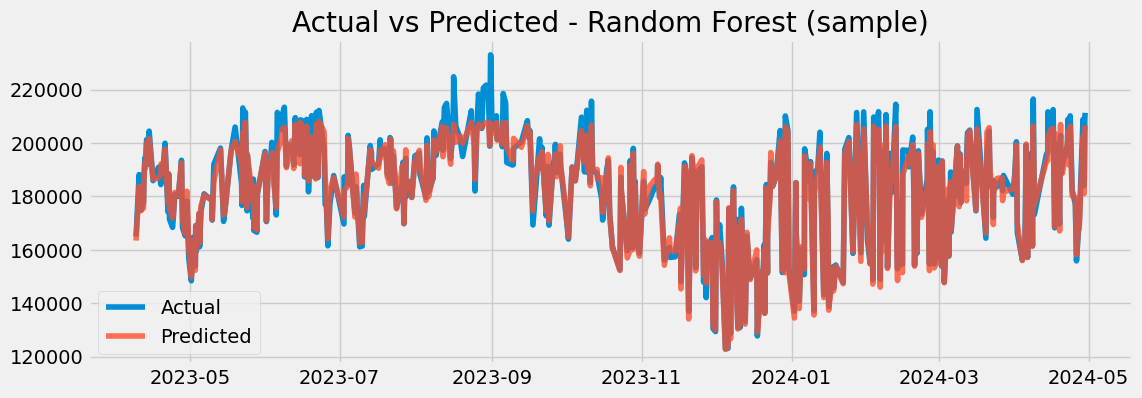

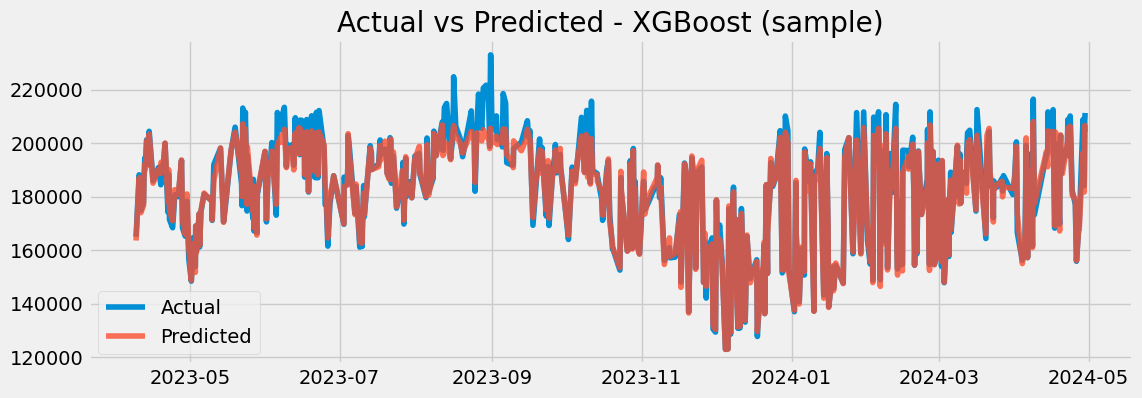

In [ ]:
#Plot Actual vs Predicted for ML models
for name, model in models.items():
    if name == 'Linear Regression':
        y_pred = model.predict(X_test_lr)
    else:
        y_pred = model.predict(X_test)

    plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    sample_df = plot_df.sample(n=min(500, len(plot_df)), random_state=SEED).sort_index()
    plt.figure(figsize=(12, 4))
    plt.plot(sample_df.index, sample_df['Actual'], label='Actual')
    plt.plot(sample_df.index, sample_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted - {name} (sample)')
    plt.legend()
    plt.show()


In [ ]:
#Sequence helper function for LSTM
def create_sequences_with_index(X_df, y_series, time_steps=24):
    Xs, ys, idx = [], [], []
    X_arr = X_df.values
    y_arr = y_series.values
    for i in range(len(X_arr) - time_steps):
        Xs.append(X_arr[i:(i+time_steps)])
        ys.append(y_arr[i+time_steps])
        idx.append(X_df.index[i+time_steps])
    return np.array(Xs), np.array(ys), pd.DatetimeIndex(idx)

TIME_STEPS = 24

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

X_train_seq, y_train_seq, train_idx_seq = create_sequences_with_index(pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns), pd.Series(y_train_scaled, index=y_train.index), TIME_STEPS)
X_test_seq, y_test_seq, test_idx_seq = create_sequences_with_index(pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns), pd.Series(y_test_scaled, index=y_test.index), TIME_STEPS)

print('LSTM sequence shapes:', X_train_seq.shape, X_test_seq.shape)


LSTM sequence shapes: (37224, 24, 19) (9288, 24, 19)


In [ ]:
# Base LSTM with GPU optimizations

tf.keras.mixed_precision.set_global_policy('mixed_float16')


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense


BATCH_SIZE = 256
lstm_model = Sequential([
    LSTM(64,
         activation='tanh',
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
         recurrent_dropout=0.1,
         return_sequences=True,
         unit_forget_bias=True),
    Dropout(0.2),
    LSTM(32,
         activation='tanh',
         recurrent_dropout=0.1),
    Dropout(0.2),
    Dense(1, dtype='float32')
])

# Model Compile
lstm_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse',
    jit_compile=True
)

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Train model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)

# Eval
training_histories = {'LSTM': history}


y_pred_scaled = lstm_model.predict(X_test_seq, batch_size=BATCH_SIZE)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_lstm = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()


mae_l = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_l = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_l = r2_score(y_test_lstm, y_pred_lstm)
mape_l = mape(y_test_lstm, y_pred_lstm)

performance_metrics['LSTM'] = {'MAE': mae_l, 'RMSE': rmse_l, 'R2 Score': r2_l, 'MAPE%': mape_l}
print(f'LSTM test RMSE={rmse_l:.2f}, R2={r2_l:.4f}, MAPE={mape_l:.2f}%')

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - loss: 0.4344 - val_loss: 0.4946 - learning_rate: 5.0000e-04
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 0.2049 - val_loss: 0.1473 - learning_rate: 5.0000e-04
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - loss: 0.1590 - val_loss: 0.6634 - learning_rate: 5.0000e-04
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1383
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - loss: 0.1383 - val_loss: 0.1856 - learning_rate: 5.0000e-04
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.1281 - val_loss: 0.0982 - learning_rate: 2.5000e-04
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 0.1002 - val_loss: 0.0752 - learning_rate: 2.5000e-04
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - loss: 0.0976 - val_loss: 0.0733 - learning_rate: 2.5000e-04
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 131

In [ ]:
# LSTM training with KerasTuner search for hyperparameter tuning
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


BATCH_SIZE = 256

def build_lstm_tunable(hp):
    model = Sequential()
    # choices
    units = hp.Int('units', 32, 128, step=32)
    stack = hp.Boolean('stack')
    dropout = hp.Float('dropout', 0.1, 0.4, step=0.1)
    lr = hp.Choice('lr', [1e-2, 1e-3, 5e-4])


    if stack:
        model.add(LSTM(units, activation='tanh', return_sequences=True,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model.add(Dropout(dropout))
        model.add(LSTM(max(16, units//2), activation='tanh'))
    else:
        model.add(LSTM(units, activation='tanh',
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', jit_compile=True)
    return model

tuner = kt.RandomSearch(
    build_lstm_tunable,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuner_tmp',
    project_name='ef'
)

callbacks_search = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

tuner.search(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=callbacks_search,
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print('Best HPs:', best_hps.values)

# Building & retraining best model
best_model = build_lstm_tunable(best_hps)
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]
history_best = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks_final,
    verbose=1,
    shuffle=False
)

# eval
y_pred_scaled_best = best_model.predict(X_test_seq, batch_size=BATCH_SIZE)
y_pred_lstm_best = scaler_y.inverse_transform(y_pred_scaled_best).flatten()
y_test_lstm_best = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()
mae_b = mean_absolute_error(y_test_lstm_best, y_pred_lstm_best)
rmse_b = np.sqrt(mean_squared_error(y_test_lstm_best, y_pred_lstm_best))
r2_b = r2_score(y_test_lstm_best, y_pred_lstm_best)
mape_b = mape(y_test_lstm_best, y_pred_lstm_best)
performance_metrics['LSTM_Tuned'] = {'MAE': mae_b, 'RMSE': rmse_b, 'R2 Score': r2_b, 'MAPE%': mape_b}
training_histories['LSTM_Tuned'] = history_best
print(f'LSTM_Tuned RMSE={rmse_b:.2f}')


Trial 5 Complete [00h 00m 14s]
val_loss: 0.04264720529317856

Best val_loss So Far: 0.012863612733781338
Total elapsed time: 00h 01m 03s
Best HPs: {'units': 96, 'stack': False, 'dropout': 0.2, 'lr': 0.01}
Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3473 - val_loss: 0.0510 - learning_rate: 0.0100
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0881 - val_loss: 0.1567 - learning_rate: 0.0100
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0766 - val_loss: 0.4248 - learning_rate: 0.0100
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0651
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0652 - val_loss: 0.1441 - learning_rate: 0.0100
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0674 - val_loss: 0.1586 - learning_rate: 0.0050
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0643 - val_loss: 0.1392 - learning_rate: 0.0050
Epoc

In [ ]:
#XGBoost randomized search
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of samples
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Fraction of features
}
xgb_base = XGBRegressor(random_state=SEED, n_jobs=-1)
xgb_search = RandomizedSearchCV(xgb_base, param_distributions=param_dist, n_iter=10, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=3), n_jobs=-1, random_state=SEED, verbose=1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print('Best XGBoost params:', xgb_search.best_params_)
y_pred_xgb = best_xgb.predict(X_test)
performance_metrics['XGBoost_Tuned'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2 Score': r2_score(y_test, y_pred_xgb),
    'MAPE%': mape(y_test, y_pred_xgb)
}
print('XGBoost tuned test RMSE=', performance_metrics['XGBoost_Tuned']['RMSE'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
XGBoost tuned test RMSE= 3985.238822763005


Generating learning curves...


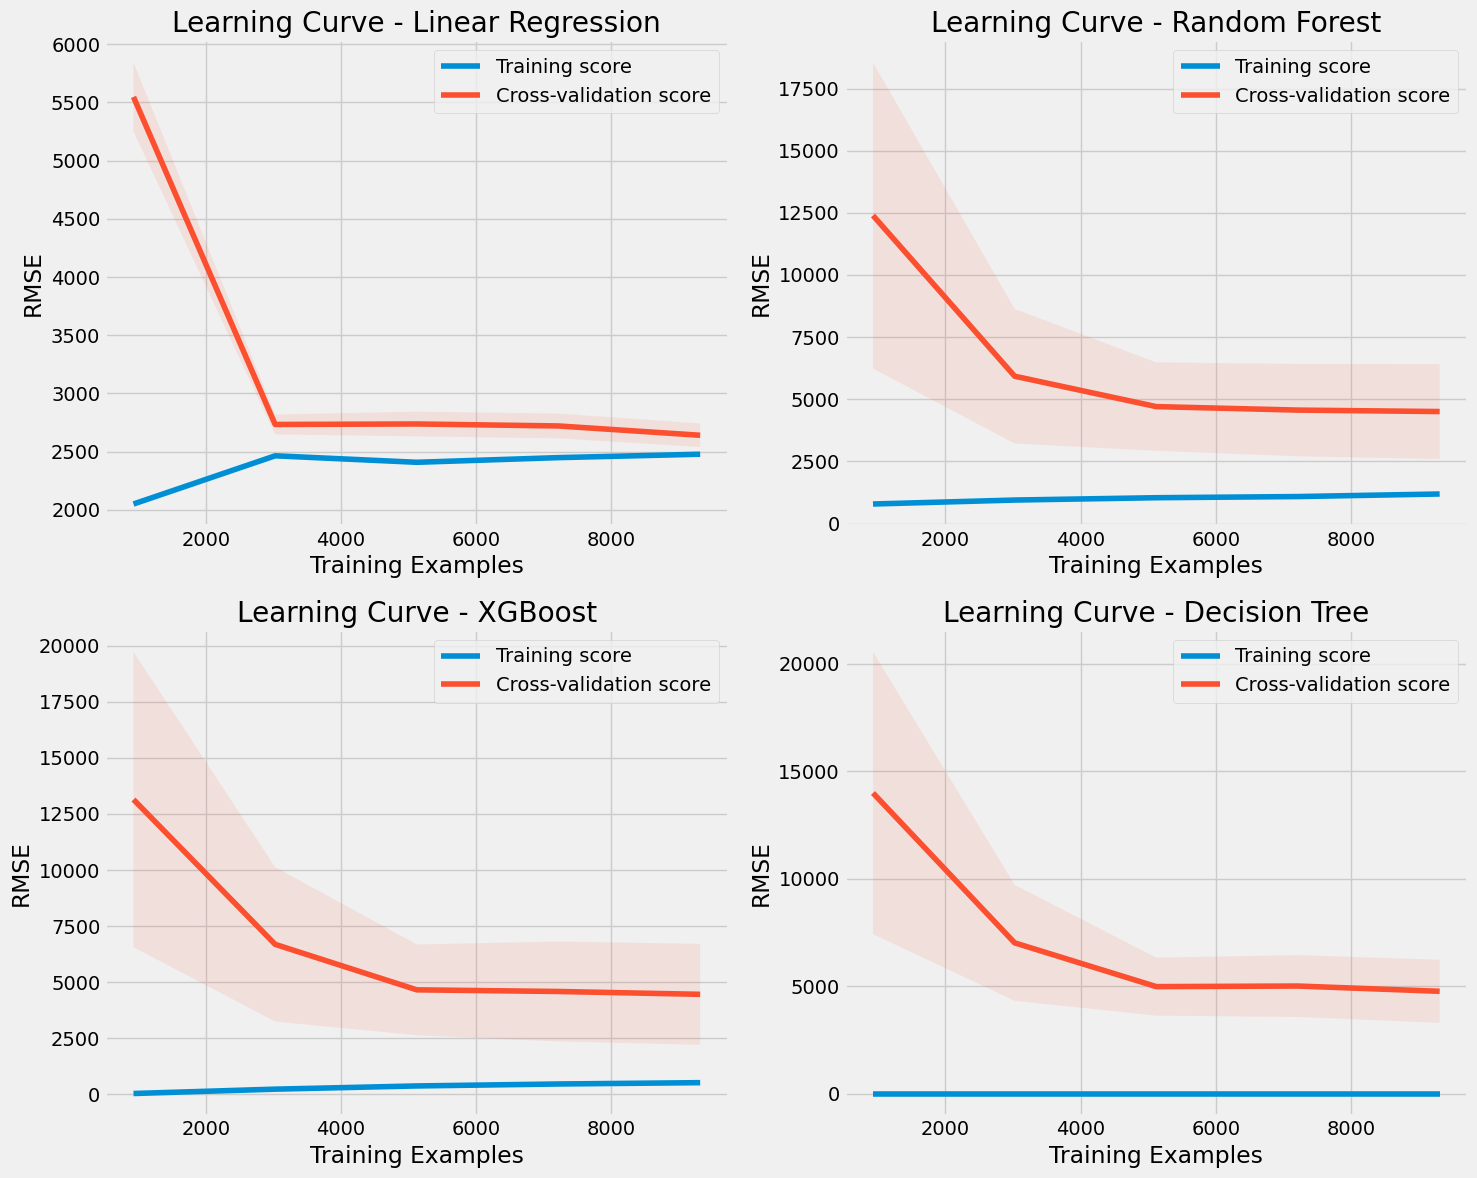


Linear Regression:
Final training RMSE: -9312.00
Final validation RMSE: 2478.30
Gap: 11790.30

Random Forest:
Final training RMSE: -9312.00
Final validation RMSE: 1188.12
Gap: 10500.12

XGBoost:
Final training RMSE: -9312.00
Final validation RMSE: 526.91
Gap: 9838.91

Decision Tree:
Final training RMSE: -9312.00
Final validation RMSE: 0.00
Gap: 9312.00


In [ ]:
# Plot Learning Curves
from sklearn.model_selection import learning_curve
import numpy as np

print("Generating learning curves...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()


models_for_curves = {
    'Linear Regression': (models['Linear Regression'], X_train_lr, y_train),
    'Random Forest': (models['Random Forest'], X_train, y_train),
    'XGBoost': (best_xgb, X_train, y_train),
    'Decision Tree': (models['Decision Tree'], X_train, y_train)
}

for idx, (name, (model, X, y)) in enumerate(models_for_curves.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)  # Negative because of scoring
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    axes[idx].plot(train_sizes, train_mean, label='Training score')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    axes[idx].plot(train_sizes, val_mean, label='Cross-validation score')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    axes[idx].set_title(f'Learning Curve - {name}')
    axes[idx].set_xlabel('Training Examples')
    axes[idx].set_ylabel('RMSE')
    axes[idx].legend(loc='best')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# convergence analysis
for name, (_, train_scores, val_scores) in zip(models_for_curves.keys(),
    [(name, -scores[0], -scores[1]) for name, scores in
     [(name, learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
                          cv=TimeSeriesSplit(n_splits=3), scoring='neg_root_mean_squared_error', n_jobs=-1))
      for name, (model, X, y) in models_for_curves.items()]]):

    final_train_score = np.mean(train_scores[-1])
    final_val_score = np.mean(val_scores[-1])
    gap = abs(final_train_score - final_val_score)

    print(f"\n{name}:")
    print(f"Final training RMSE: {final_train_score:.2f}")
    print(f"Final validation RMSE: {final_val_score:.2f}")
    print(f"Gap: {gap:.2f}")


Convergence Analysis:

XGBoost Tuned:
Training RMSE: 18993.08 → 954.95
Test RMSE: 33737.94 → 3985.24
Final gap: 3030.29

Base LSTM:
Training loss: 0.3740 → 0.0624
Validation loss: 0.4946 → 0.0595
Final gap: 0.0029

Tuned LSTM:
Training loss: 0.1789 → 0.0162
Validation loss: 0.0510 → 0.0185
Final gap: 0.0023


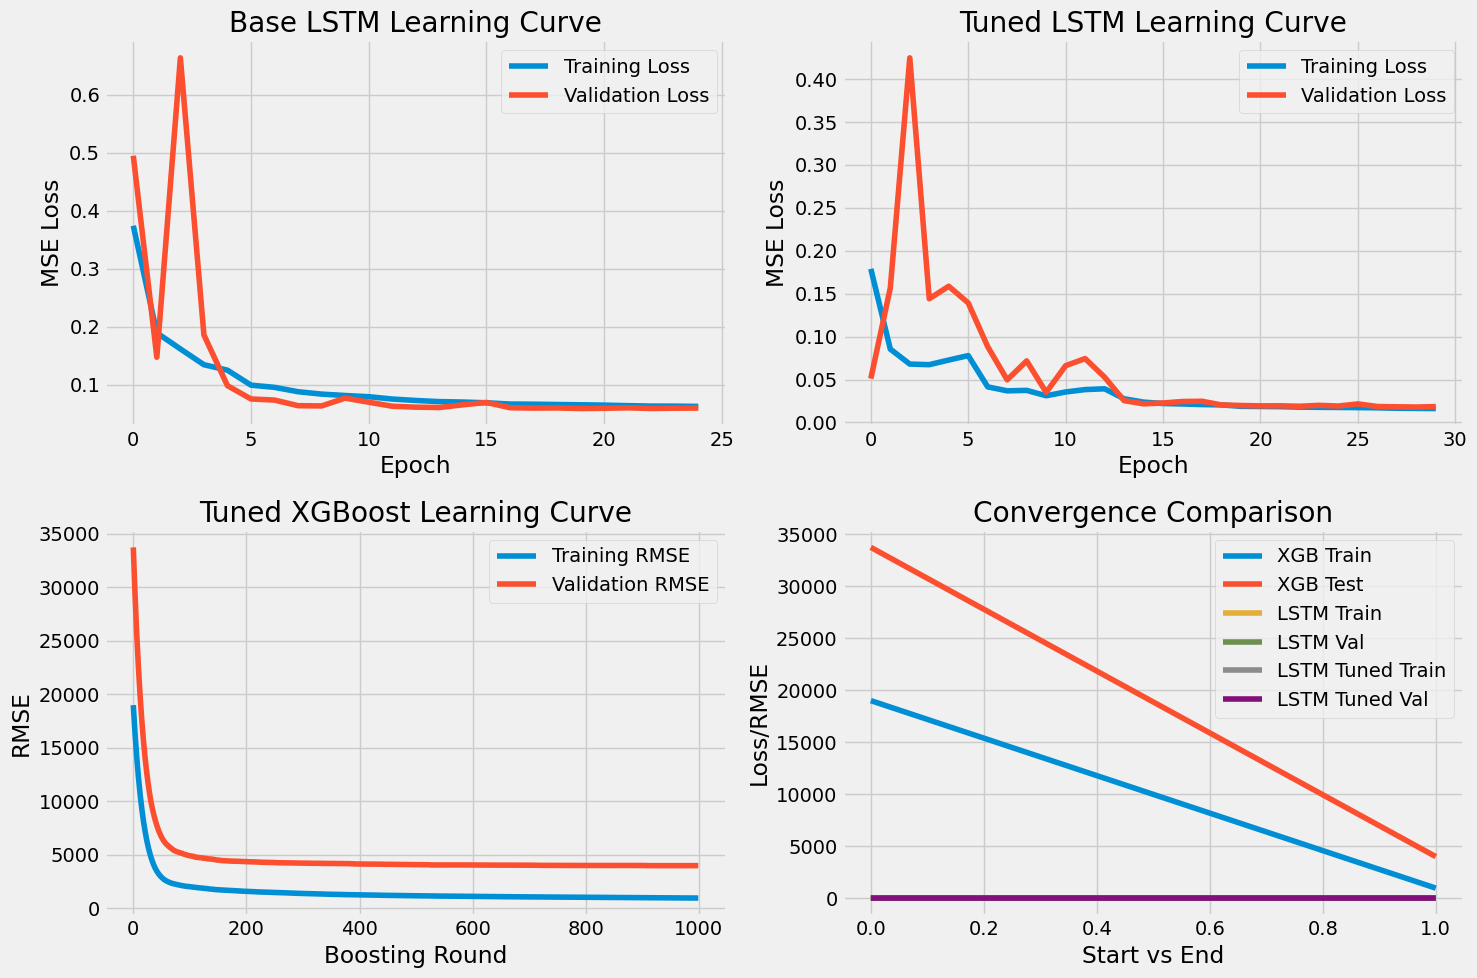

In [ ]:
# Plot Learning Curves for LSTM, Tuned LSTM, and Tuned XGBoost
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Plot LSTM
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Base LSTM Learning Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Tuned LSTM
axes[1].plot(history_best.history['loss'], label='Training Loss')
axes[1].plot(history_best.history['val_loss'], label='Validation Loss')
axes[1].set_title('Tuned LSTM Learning Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()
axes[1].grid(True)

# XGBoost tuned model
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_eval = XGBRegressor(**xgb_search.best_params_, random_state=SEED, n_jobs=-1)
xgb_eval.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)


train_scores = xgb_eval.evals_result()['validation_0']['rmse']
test_scores = xgb_eval.evals_result()['validation_1']['rmse']

axes[2].plot(train_scores, label='Training RMSE')
axes[2].plot(test_scores, label='Validation RMSE')
axes[2].set_title('Tuned XGBoost Learning Curve')
axes[2].set_xlabel('Boosting Round')
axes[2].set_ylabel('RMSE')
axes[2].legend()
axes[2].grid(True)

# convergence analysis
print("\nConvergence Analysis:")
print("\nXGBoost Tuned:")
print(f"Training RMSE: {train_scores[0]:.2f} → {train_scores[-1]:.2f}")
print(f"Test RMSE: {test_scores[0]:.2f} → {test_scores[-1]:.2f}")
print(f"Final gap: {abs(train_scores[-1] - test_scores[-1]):.2f}")

print("\nBase LSTM:")
print(f"Training loss: {history.history['loss'][0]:.4f} → {history.history['loss'][-1]:.4f}")
print(f"Validation loss: {history.history['val_loss'][0]:.4f} → {history.history['val_loss'][-1]:.4f}")
print(f"Final gap: {abs(history.history['loss'][-1] - history.history['val_loss'][-1]):.4f}")

print("\nTuned LSTM:")
print(f"Training loss: {history_best.history['loss'][0]:.4f} → {history_best.history['loss'][-1]:.4f}")
print(f"Validation loss: {history_best.history['val_loss'][0]:.4f} → {history_best.history['val_loss'][-1]:.4f}")
print(f"Final gap: {abs(history_best.history['loss'][-1] - history_best.history['val_loss'][-1]):.4f}")

# convergence analysis plot
axes[3].plot([train_scores[0], train_scores[-1]], label='XGB Train')
axes[3].plot([test_scores[0], test_scores[-1]], label='XGB Test')
axes[3].plot([history.history['loss'][0], history.history['loss'][-1]], label='LSTM Train')
axes[3].plot([history.history['val_loss'][0], history.history['val_loss'][-1]], label='LSTM Val')
axes[3].plot([history_best.history['loss'][0], history_best.history['loss'][-1]], label='LSTM Tuned Train')
axes[3].plot([history_best.history['val_loss'][0], history_best.history['val_loss'][-1]], label='LSTM Tuned Val')
axes[3].set_title('Convergence Comparison')
axes[3].set_xlabel('Start vs End')
axes[3].set_ylabel('Loss/RMSE')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()




Final Model Comparison:


,MAE,RMSE,R2 Score,MAPE%
Linear Regression,2260.531334,2988.105289,0.976637,1.239578
LSTM_Tuned,2589.083938,3403.789119,0.969731,1.400185
XGBoost_Tuned,2362.097882,3985.238823,0.958443,1.210537
XGBoost,2460.454840,4052.561087,0.957028,1.265976
Random Forest,2783.995827,4072.988668,0.956593,1.463310
Decision Tree,3392.288428,4749.005733,0.940989,1.796665
LSTM,5943.351381,7684.365171,0.845729,3.143806


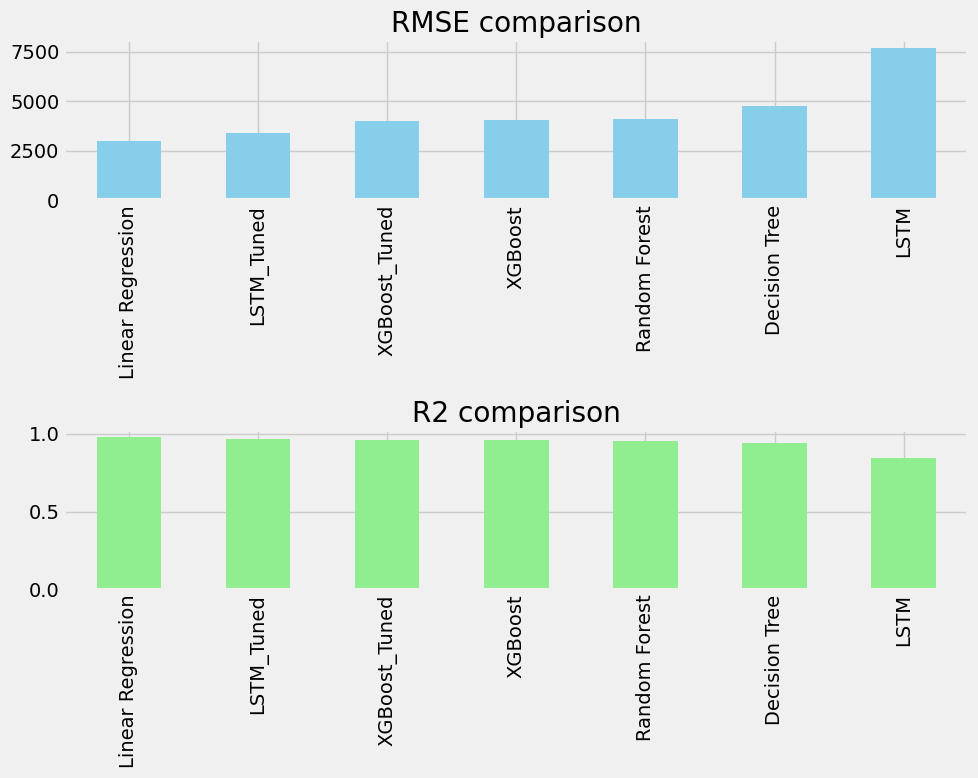

In [ ]:
# Comparision
perf_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
perf_df = perf_df.sort_values(by='RMSE')
print('\nFinal Model Comparison:')
display(perf_df)

fig, axes = plt.subplots(2,1, figsize=(10,8))
perf_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('RMSE comparison')
perf_df['R2 Score'].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('R2 comparison')
plt.tight_layout()
plt.show()

Best non-linear model for plotting: LSTM_Tuned


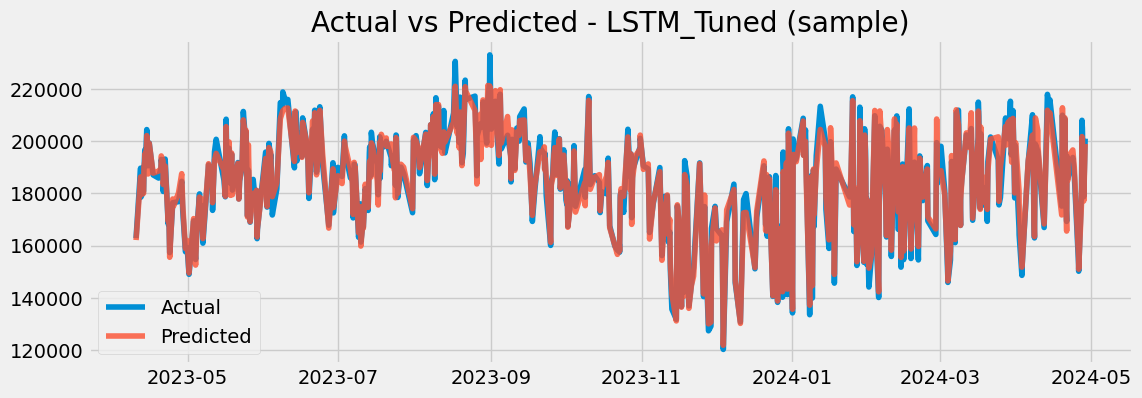

In [ ]:
# Ploting actual vs predicted for best non linear model

non_linear_models = perf_df.index[~perf_df.index.isin(['Linear Regression'])]
best_non_linear_model_name = perf_df.loc[non_linear_models]['RMSE'].idxmin()
print(f'Best non-linear model for plotting: {best_non_linear_model_name}')

if best_non_linear_model_name in ['LSTM','LSTM_Tuned']:
    if best_non_linear_model_name == 'LSTM':
        preds = y_pred_lstm
        idx = test_idx_seq
        actual = pd.Series(y_test_lstm, index=idx)
    else:
        preds = y_pred_lstm_best
        idx = test_idx_seq
        actual = pd.Series(y_test_lstm_best, index=idx)
else:
    model = {'Decision Tree': models['Decision Tree'],
             'Random Forest': models['Random Forest'],
             'XGBoost': models['XGBoost'],
             'XGBoost_Tuned': best_xgb}[best_non_linear_model_name]
    preds = model.predict(X_test)
    actual = y_test
    idx = actual.index


plot_df = pd.DataFrame({'Actual': actual.values.flatten(), 'Predicted': preds.flatten()}, index=idx)

sample_df = plot_df.sample(n=min(500, len(plot_df)), random_state=SEED).sort_index()

plt.figure(figsize=(12, 4))
plt.plot(sample_df.index, sample_df['Actual'], label='Actual')
plt.plot(sample_df.index, sample_df['Predicted'], label='Predicted', alpha=0.8)
plt.title(f'Actual vs Predicted - {best_non_linear_model_name} (sample)')
plt.legend()
plt.show()

Best non-linear model: LSTM_Tuned


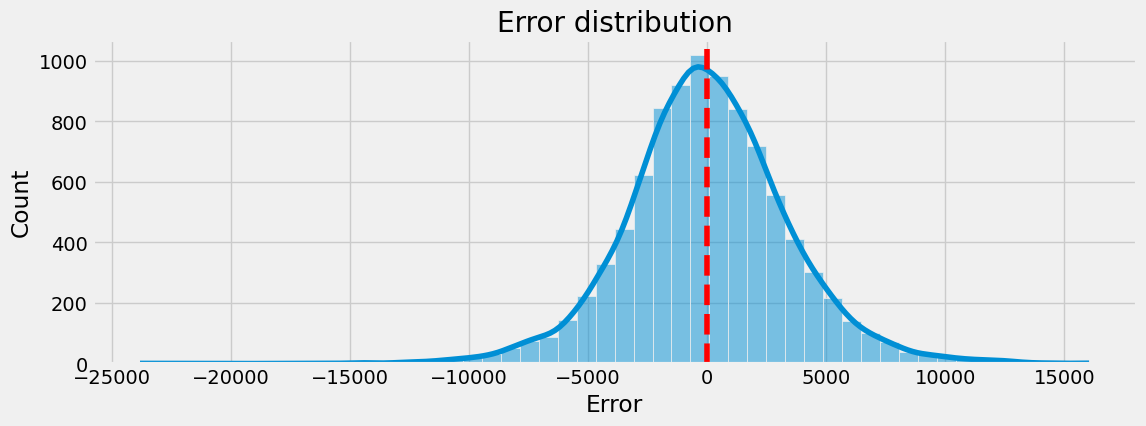

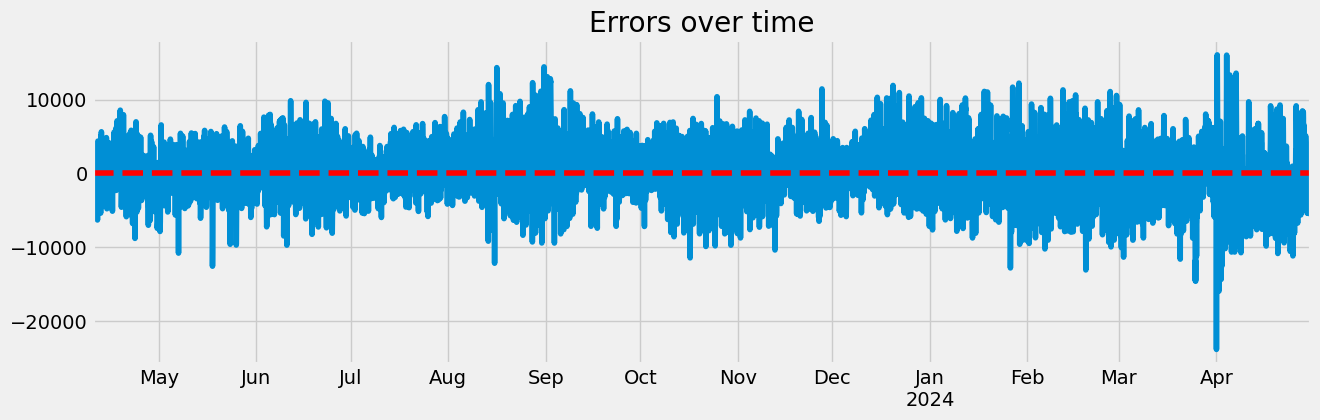

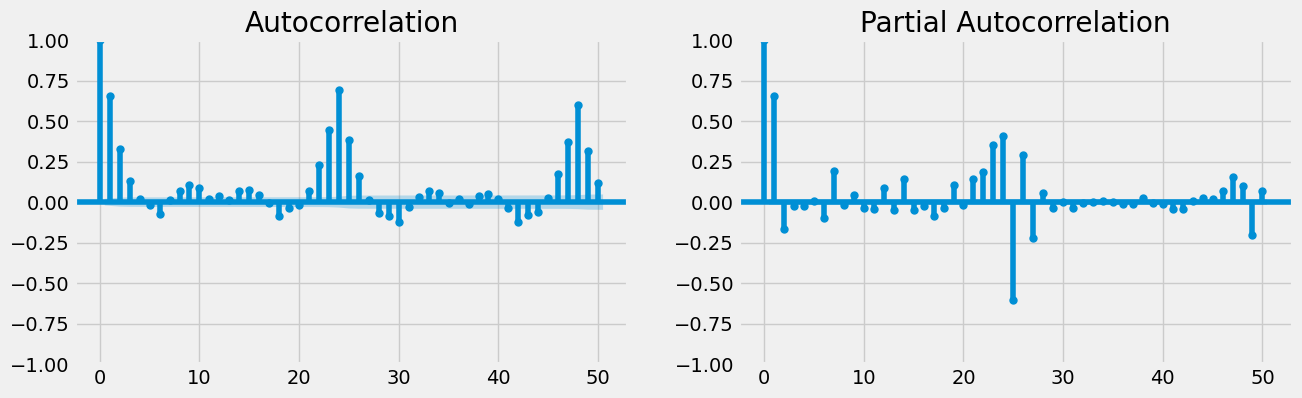

In [ ]:
# Error Analysis
non_linear = perf_df.index[perf_df.index != 'Linear Regression']
best_non_linear = perf_df.loc[non_linear]['RMSE'].idxmin()
print('Best non-linear model:', best_non_linear)

if best_non_linear in ['LSTM','LSTM_Tuned']:
    if best_non_linear == 'LSTM':
        preds = y_pred_lstm
        idx = test_idx_seq
        actual = pd.Series(y_test_lstm, index=idx)
    else:
        preds = y_pred_lstm_best
        idx = test_idx_seq
        actual = pd.Series(y_test_lstm_best, index=idx)
else:
    model = {'Decision Tree': models['Decision Tree'], 'Random Forest': models['Random Forest'], 'XGBoost': models['XGBoost'], 'XGBoost_Tuned': best_xgb}[best_non_linear]
    preds = model.predict(X_test)
    actual = y_test
    idx = actual.index

errors = actual.values.flatten() - np.array(preds).flatten()
error_idx = idx
error_df = pd.DataFrame({'Error': errors}, index=error_idx)

plt.figure(figsize=(12,4))
sns.histplot(error_df['Error'], kde=True, bins=50)
plt.title('Error distribution')
plt.axvline(0, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(14,4))
error_df['Error'].plot()
plt.title('Errors over time')
plt.axhline(0, color='red', linestyle='--')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf(error_df['Error'], lags=50, ax=ax[0])
plot_pacf(error_df['Error'], lags=50, ax=ax[1])
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Forecast model params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


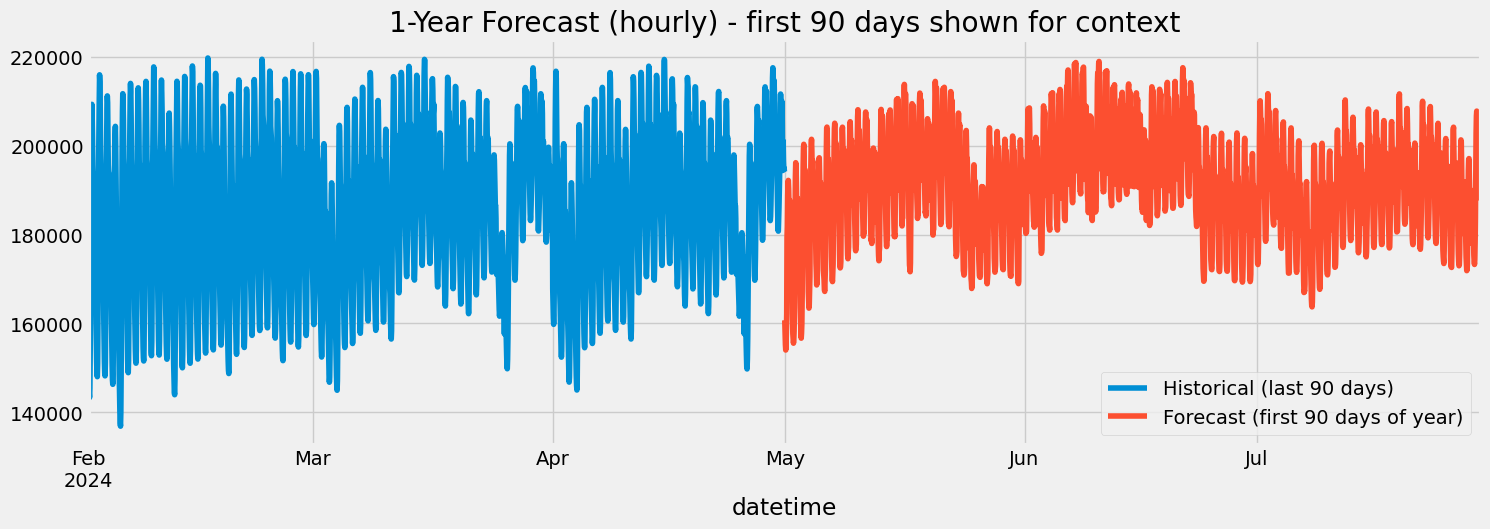

In [ ]:
#1-Year hourly forecast using time-only features
time_feats = ['hour_s','hour_c','dayofweek','month_s','month_c','year','quarter','doy_s','doy_c']
X_fore = df_processed[time_feats]
y_fore = df_processed[TARGET_COL]


param_dist_fore = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}
fore_search = RandomizedSearchCV(XGBRegressor(random_state=SEED, n_jobs=-1), param_distributions=param_dist_fore, n_iter=10, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=3), n_jobs=-1, random_state=SEED, verbose=1)
fore_search.fit(X_fore, y_fore)
fore_model = fore_search.best_estimator_
print('Forecast model params:', fore_search.best_params_)

last_date = df_processed.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=24*365, freq='H')
future = pd.DataFrame(index=future_dates)
future['hour'] = future.index.hour
future['dayofweek'] = future.index.dayofweek
future['month'] = future.index.month
future['year'] = future.index.year
future['quarter'] = future.index.quarter
future['dayofyear'] = future.index.dayofyear
future['hour_s'] = np.sin(2 * np.pi * future.index.hour / 24)
future['hour_c'] = np.cos(2 * np.pi * future.index.hour / 24)
future['month_s'] = np.sin(2 * np.pi * (future.index.month - 1) / 12)
future['month_c'] = np.cos(2 * np.pi * (future.index.month - 1) / 12)
future['doy_s'] = np.sin(2 * np.pi * future.index.dayofyear / 365.25)
future['doy_c'] = np.cos(2 * np.pi * future.index.dayofyear / 365.25)

future_preds = fore_model.predict(future[time_feats])
future['Forecast'] = future_preds

plt.figure(figsize=(16,5))
df_processed[TARGET_COL].iloc[-24*90:].plot(label='Historical (last 90 days)')
future['Forecast'].iloc[:24*90].plot(label='Forecast (first 90 days of year)')
plt.title('1-Year Forecast (hourly) - first 90 days shown for context')
plt.legend()
plt.show()
